# Visualize "mutation matrices"

Using the data generated in the `MutationMatrices` notebook.

This visualizes mutation matrices both for codons (e.g. ATG, TGC) and amino acids (e.g. M, C).

In [1]:
%run "Header.ipynb"
import json
import copy
import skbio

## Load JSON mutation matrix data

These files are relatively small, compared with the huge (ish) JSONs generated by the main workflow code. So, thankfully, fiddling around with these plots on a laptop is pretty doable.

In [2]:
with open("matrix-jsons/codon2codon2freq.json", "r") as f:
    codon2codon2freq = json.load(f)
    
with open("matrix-jsons/codon2freq.json", "r") as f:
    codon2freq = json.load(f)
    
with open("matrix-jsons/aa2aa2freq.json", "r") as f:
    aa2aa2freq = json.load(f)
    
with open("matrix-jsons/aa2freq.json", "r") as f:
    aa2freq = json.load(f)

## Check codon/amino acid frequencies

Just for reference.

In [3]:
print(codon2freq)
# Based on https://stackoverflow.com/a/280156.
maxfreqcodon = max(codon2freq, key=codon2freq.get)
print("Max freq codon: {} (freq = {:,})".format(maxfreqcodon, codon2freq[maxfreqcodon]))
minfreqcodon = min(codon2freq, key=codon2freq.get)
print("Min freq codon: {} (freq = {:,})".format(minfreqcodon, codon2freq[minfreqcodon]))

{'AAA': 132293, 'AAC': 52799, 'AAG': 49601, 'AAT': 87423, 'ACA': 49052, 'ACC': 33587, 'ACG': 15709, 'ACT': 38169, 'AGA': 33066, 'AGC': 35426, 'AGG': 7592, 'AGT': 36317, 'ATA': 71153, 'ATC': 45053, 'ATG': 64253, 'ATT': 86734, 'CAA': 55742, 'CAC': 21493, 'CAG': 22925, 'CAT': 22519, 'CCA': 26441, 'CCC': 22413, 'CCG': 14250, 'CCT': 25578, 'CGA': 11874, 'CGC': 29211, 'CGG': 3138, 'CGT': 25767, 'CTA': 28901, 'CTC': 34549, 'CTG': 22009, 'CTT': 51543, 'GAA': 92575, 'GAC': 49237, 'GAG': 76747, 'GAT': 93109, 'GCA': 67510, 'GCC': 41731, 'GCG': 18331, 'GCT': 62962, 'GGA': 58899, 'GGC': 43947, 'GGG': 12871, 'GGT': 51276, 'GTA': 50629, 'GTC': 24113, 'GTG': 32600, 'GTT': 51247, 'TAA': 4313, 'TAC': 29558, 'TAG': 1358, 'TAT': 73523, 'TCA': 37593, 'TCC': 16737, 'TCG': 16052, 'TCT': 28845, 'TGA': 2256, 'TGC': 15425, 'TGG': 25315, 'TGT': 16290, 'TTA': 59684, 'TTC': 39989, 'TTG': 39006, 'TTT': 79720}
Max freq codon: AAA (freq = 132,293)
Min freq codon: TAG (freq = 1,358)


In [4]:
print(aa2freq)
maxfreqaa = max(aa2freq, key=aa2freq.get)
print("Max freq amino acid/stop codon: {} (freq = {:,})".format(maxfreqaa, aa2freq[maxfreqaa]))
minfreqaa = min(aa2freq, key=aa2freq.get)
print("Min freq amino acid/stop codon: {} (freq = {:,})".format(minfreqaa, aa2freq[minfreqaa]))

{'L': 235692, 'Y': 103081, 'R': 110648, '*': 7927, 'M': 64253, 'W': 25315, 'E': 169322, 'A': 190534, 'I': 202940, 'Q': 78667, 'C': 31715, 'S': 170970, 'F': 119709, 'K': 181894, 'H': 44012, 'N': 140222, 'D': 142346, 'V': 158589, 'T': 136517, 'P': 88682, 'G': 166993}
Max freq amino acid/stop codon: L (freq = 235,692)
Min freq amino acid/stop codon: * (freq = 7,927)


### Compute aa2synmutfreq mapping

Maps amino acids (+ the stop codon) to the number of _synonymous_ mutations observed in the codon mutation matrix.

We'll display this info in the diagonal of the amino acid mutation matrix, rather than just the raw count of amino acids/stop codons seen.

In the future, if/when we shift to the amino acid mutation matrix being independent of the codon matrix, this might need to be done elsewhere -- not entirely sure right now. Worth thinking about.

In [5]:
trans = lambda codon: str(skbio.DNA(codon).translate())

aa2synmutfreq = {aa: 0 for aa in aa2freq.keys()}
for codon in codon2codon2freq.keys():
    codon_trans = trans(codon)
    for mut_codon in codon2codon2freq[codon].keys():
        mut_codon_trans = trans(mut_codon)
        if codon_trans == mut_codon_trans:
            aa2synmutfreq[codon_trans] += codon2codon2freq[codon][mut_codon]

In [6]:
aa2synmutfreq

{'L': 1977,
 'Y': 617,
 'R': 1045,
 '*': 16,
 'M': 0,
 'W': 0,
 'E': 1212,
 'A': 2064,
 'I': 1304,
 'Q': 316,
 'C': 261,
 'S': 1559,
 'F': 667,
 'K': 859,
 'H': 212,
 'N': 889,
 'D': 813,
 'V': 1333,
 'T': 1540,
 'P': 1366,
 'G': 2937}

## Actually visualize matrices

Much of the matplotlib code in this function is based on [these docs](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).

We define some utility functions first which can be used with generalized "obj"s instead of codons or amino acids specifically. This is because most of the code generalizes to both types of matrix.

The general idea of "you might as well define your own functions for this" was another thing I derived from the aforementioned matplotlib docs.

In [7]:
# Get the tab20 color map. This returns an object that we can call with, e.g. (0) to get the first
# color, (1) to get the second color, etc. See https://stackoverflow.com/a/25408562.
# (List of matplotlib color maps: https://matplotlib.org/stable/gallery/color/colormap_reference.html)
cmap = matplotlib.cm.get_cmap("tab20")
colors = [cmap(i) for i in range(20)]
hexcolors = [matplotlib.colors.to_hex(c) for c in colors]

# Map the 20 amino acids to a unique tab20 color, and then keep the stop codon (item 21)'s text color as black
# so that it has a unique color.
aa2color = {}
aas = sorted(list(aa2freq.keys()))
aas.remove("*")
for i, aa in enumerate(aas):
    aa2color[aa] = hexcolors[i]
aa2color["*"] = "#000000"

aa2color

{'A': '#1f77b4',
 'C': '#aec7e8',
 'D': '#ff7f0e',
 'E': '#ffbb78',
 'F': '#2ca02c',
 'G': '#98df8a',
 'H': '#d62728',
 'I': '#ff9896',
 'K': '#9467bd',
 'L': '#c5b0d5',
 'M': '#8c564b',
 'N': '#c49c94',
 'P': '#e377c2',
 'Q': '#f7b6d2',
 'R': '#7f7f7f',
 'S': '#c7c7c7',
 'T': '#bcbd22',
 'V': '#dbdb8d',
 'W': '#17becf',
 'Y': '#9edae5',
 '*': '#000000'}

In [40]:
def get_text_color(val, max_val, min_cutoff_for_black_text=0.5):
    # Show black or white text, depending on how this cell's value compares to the max.
    # This is a crude way of doing this; could also look at the luminosity (?) of this color.
    # But it looks ok enough :)
    # (I didn't notice until after I wrote this, but the example I linked in mpl's docs also does
    # something similar, albeit in a way that looks much more elegant :)
    if val / max_val >= min_cutoff_for_black_text:
        return "#000000"
    else:
        return "#ffffff"
        
def viz_mutmatrix(
    objs,
    obj2freq,
    obj2obj2freq,
    objdesc,
    cmap_name,
    show_syn_nonsyn_vectors=False,
    w=22,
    h=22,
    rotate_xlabels=True,
    show_ticks=True,
    normalize_rows=True,
    figfilename=None,
    custom_diag_map=None,
):
    """Visualizes a mutation matrix.
    
    In theory this function was supposed to be all generalized and fancy and stuff, but then adding
    Syn/NonSyn vectors for the codon matrix resulted in a ton of complexity... oh well. It works!
    
    objs: list
        Sorted list of objects (e.g. codon strings, amino acid strings). This order will be used for
        the x and y axes of the plot.
        
    obj2freq: dict
        Maps object strings (the stuff in objs) to their frequencies in the dataset. These frequencies
        will be shown as text in the diagonal of the matrix, unless custom_diag_map is passed.
        
    obj2obj2freq: dict
        Maps object strings to another dict. Each dict (the value of key "o1") maps all of the other
        object strings besides o1 to the frequency with which we saw a mutation from o1 into these other
        objects. (So -- if we're working with codons, for example -- then the outermost dict should have
        64 elements and each inner dict should have 63 elements.)
        
    objdesc: str
        Name of the object, in title-case (e.g. "Codon"). Used in adding labels/titles to the figure.
    
    cmap_name: str
        Name of the colormap to use in matplotlib.
        See https://matplotlib.org/stable/tutorials/colors/colormaps.html.
        
    show_syn_nonsyn_vectors: bool
        If True, this will interpret each of the objs as codons, and plot two extra vectors (represented
        as columns) next to the matrix. The value of each cell in Syn is the sum of all synonymous mutations
        in that row in the matrix; the value of each cell in NonSyn is the sum of all nonsynonymous mutations
        in that row in the matrix.
        
        This flag also controls a few other "codon-matrix-specific" things, e.g. coloring matrix cells as green
        or white depending on if they represent a synonymous or nonsynonymous mutation. Basically, this should be
        True for codon matrices and False for other matrices.
        
    w: some sort of number
    h: some sort of number
        The width and height, in inches, that we pass to fig.set_size_inches().
        
    rotate_xlabels: bool
        If True, will rotate the x-axis labels by -45 degrees. Useful if there are a lot of object strings
        and they each have multiple characters. If False, won't rotate these labels.
        
    show_ticks: bool
        If True, will show ticks next to axis labels; if False, won't (but will still show labels).
        
    normalize_rows: bool
        If True, this will divide each cell by the obj2freq entry for its row.
        
    figfilename: str or None
        If not None, this'll save the figure to this filename in figs/.
        
    custom_diag_map: dict or None
        If not None, this'll be used to populate the diagonal of the matrix (should have the same dimensions
        as obj2freq, and the values should be numbers). If this is passed, the diagonal will actually be kept
        colored.
    """
    
    # Convert from a dict of dicts to just a 2D list, so we can use imshow.
    # The document I linked above uses NumPy arrays, but lists are ok also (...as far as I can tell).
    obj_matrix = []
    syn = []
    nonsyn = []
    freqcol = []
    # Search for min / max vals across both the matrix and Syn and NonSyn -- we want them to use the same
    # scale to simplify interpretation, and the way to do this is to figure out the global min and max.
    # See https://stackoverflow.com/a/34183501.
    min_val = float("inf")
    max_val = float("-inf")
    
    # Save text to include in the syn and nonsyn columns
    syn_text = []
    nonsyn_text = []
    for row_obj in objs:
        row = []
        rowsyn = 0
        rownonsyn = 0
        
        rowsynraw = 0
        rownonsynraw = 0
        for col_obj in objs:
            if row_obj == col_obj and custom_diag_map is None:
                # We don't have data for "mutations" for an object into itself, so we assign the diagonal
                # of the matrix a special NaN value. And we'll later assign these NaN values a unique color.
                # See https://stackoverflow.com/a/46649061.
                row.append(float("nan"))
            else:
                if row_obj == col_obj:
                    raw_freq = custom_diag_map[row_obj]
                else:
                    raw_freq = obj2obj2freq[row_obj][col_obj]
                    
                if normalize_rows:
                    freq = raw_freq / obj2freq[row_obj]
                else:
                    freq = raw_freq
                min_val = min(min_val, freq)
                max_val = max(max_val, freq)
                row.append(freq)
                if show_syn_nonsyn_vectors:
                    is_synonymous = (str(skbio.DNA(row_obj).translate()) == str(skbio.DNA(col_obj).translate()))
                    if is_synonymous:
                        rowsyn += freq
                        rowsynraw += raw_freq
                    else:
                        rownonsyn += freq
                        rownonsynraw += raw_freq
        obj_matrix.append(row)
        if show_syn_nonsyn_vectors:
            syn.append([rowsyn])
            nonsyn.append([rownonsyn])
            syn_text.append(rowsynraw)
            nonsyn_text.append(rownonsynraw)
            min_val = min(min_val, rowsyn)
            min_val = min(min_val, rownonsyn)
            max_val = max(max_val, rowsyn)
            max_val = max(max_val, rownonsyn)
            
        if custom_diag_map is not None:
            freqcol.append([obj2freq[row_obj]])

    if show_syn_nonsyn_vectors:
        # Use of width ratios based on https://matplotlib.org/stable/tutorials/intermediate/gridspec.html,
        # which I found myself at from https://stackoverflow.com/a/5084192 and the other answers therein.
        # Other stuff on the gridspec docs page didn't work for me for some reason (constrained_layout
        # didn't seem available? I might've just been doing stuff wrong); however, using gridspec_kw seems ok.
        #
        # The 4 and 3 ratios were chosen based on messing around with this -- it looks like these ratios differ
        # between the versions of matplotlib (?and/or other confounding variables, e.g. OS version / Jupyter
        # version / ...) on my laptop and on the cluster. I've set things up so these work with the cluster.
        #
        # Initially I had this so that axSyn and axNonSyn had ratios of 1 and 1 in comparison with the matrix
        # axis, but these numbers work better. I guess the way to think of this is that the axSyn legend, and
        # the axSyn / axNonSyn titles, take up extra space beyond a single column of the matrix.
        #
        # (There's probably a more precise way of setting this up that avoids the need for manually tweaking
        # the ratios, but this is probably fine...)
        fig, (ax, axSyn, axNonSyn) = pyplot.subplots(nrows=1, ncols=3, sharey=True, gridspec_kw={
            "width_ratios": [64, 4, 3]
        })
    else:
        if custom_diag_map is not None:
            # Similar approach for the AA matrix
            fig, (ax, axFreq) = pyplot.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={
                "width_ratios": [21, 1.5]
            })
        else:
            # tldr, you have to either be doing a codon or aa matrix. can't do some weird hybrid.
            # well you totally could, but i'm not about to write a full-on library for displaying these
            # matrices considering this is just for figures for a paper.
            # or maybe i will do that lmao idk
            raise ValueError("Currently you have to have either syn/nonsyn or the frequency columns shown")

    # Given a colormap we want to use, modify it so that NaNs are assigned a special color.
    # Based on https://stackoverflow.com/a/46649061.
    # (Making a copy of the colormap first to avoid matplotlib warning about modifying a colormap in-place.
    # For some reason copy.deepcopy() doesn't remove the warning, but copy.copy() does.)
    cmap = copy.copy(matplotlib.cm.get_cmap(cmap_name))
    cmap.set_bad(color="#cccccc")
    im = ax.imshow(obj_matrix, cmap=cmap, vmin=min_val, vmax=max_val)
    
    # Show top ticks but not bottom ticks; also, show the x-axis labels
    # on top instead of on bottom.
    ax.tick_params(
        top=show_ticks, bottom=False, left=show_ticks, right=False,
        labeltop=True, labelbottom=False, labelleft=True, labelright=False
    )
    # https://stackoverflow.com/a/14406447
    ax.xaxis.set_label_position("top")
        
    # As in "tick i's". This specifies where to put all the ticks.
    tick_is = range(len(objs))
    ax.set_xticks(tick_is)
    ax.set_yticks(tick_is)
    
    # show Syn and NonSyn
    if show_syn_nonsyn_vectors:
        axSyn.imshow(syn, cmap=cmap, vmin=min_val, vmax=max_val)
        axNonSyn.imshow(nonsyn, cmap=cmap, vmin=min_val, vmax=max_val)
        axSyn.set_title("$Syn$")
        axNonSyn.set_title("$NonSyn$")
        
        for a in (axSyn, axNonSyn):
            a.grid(False)
            a.tick_params(bottom=False, labelbottom=False)
            
        axSyn.tick_params(labelleft=True)
        axNonSyn.tick_params(left=False)
        
        formattext = lambda val: f"{val}"
        
        for i in tick_is:
            axSyn.text(
                0, i, formattext(syn_text[i]),
                ha="center", va="center", color=get_text_color(syn[i][0], max_val)
            )
            axNonSyn.text(
                0, i, formattext(nonsyn_text[i]),
                ha="center", va="center", color=get_text_color(nonsyn[i][0], max_val)
            )
    
    if custom_diag_map is not None:
        # We just want the colormap to always output gray.
        # See https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html for details.
        just_gray_cmap = matplotlib.colors.ListedColormap(["#cccccc"])
        axFreq.imshow(freqcol, cmap=just_gray_cmap)
        axFreq.set_title("Freq")
        axFreq.grid(False)
        axFreq.tick_params(bottom=False, labelbottom=False, labelleft=True, left=show_ticks)
    
    # Convenience function to avoid code reuse. ticklabel is the sorta thing that ax.get_xticklabels()
    # returns a collection of.
    def set_text_style(ticklabel, fontsize="xx-large"):
        tl.set_fontweight("bold")
        tl.set_fontfamily("monospace")
        tl.set_fontsize(fontsize)
    
    # Set assigned colors for amino acids based on aa2color.
    # Also set colors for codons based on their translations.
    # This method of setting colors based on https://stackoverflow.com/a/4762002.
    if show_syn_nonsyn_vectors:
        # This is for the codon matrix. We want to add an extra row to the x-axis labels showing
        # the translations, as well as an extra column to the y-axis labels also showing the translations.
        # We *could* mess around with actually creating a new row/column using some fancy stuff (e.g. as
        # shown here: https://stackoverflow.com/a/42763429), but we take a similar albeit simpler approach:
        # since we really just want to show a one-to-one mapping of codons -> amino acids (or stop codons),
        # we just modify each codon label to include its translation.
        toplabels = []
        leftlabels = []
        for oi, o in enumerate(objs):
            t = skbio.DNA(o).translate()
            toplabels.append(f"{t}\n{o}")
            leftlabels.append(f"{t} {o}")
        
        ax.set_xticklabels(toplabels)
        ax.set_yticklabels(leftlabels)
        # Weirdly enough, if you omit this next line then axSyn still has the same labels as the matrix
        # (however, they're unstyled). Strangely enough, when you call axSyn.get_yticklabels() after not
        # setting the y-tick labels on axSyn explicitly, there *are* 64 y-tick labels -- but calling
        # get_text() on them returns "". I assume this is due to some inherited default setting that axSyn
        # has, or something. Anyway: setting the y-tick labels here lets us easily and confidently
        # set color for each of these 64 labels. tldr: programming is hard :|
        axSyn.set_yticklabels(leftlabels)
        
        for axlabelset in (ax.get_yticklabels(), axSyn.get_yticklabels()):
            for tl in axlabelset:
                tl.set_color(aa2color[tl.get_text().split()[0]])
                set_text_style(tl)
                
        # Keep the x-axis at "large" font size, to avoid stuff spilling over.
        for tl in ax.get_xticklabels():
            tl.set_color(aa2color[tl.get_text().split()[0]])
            set_text_style(tl, "large")
    else:
        ax.set_xticklabels(objs)
        ax.set_yticklabels(objs)
        axFreq.set_yticklabels(objs)
        for axlabelset in (ax.get_xticklabels(), ax.get_yticklabels(), axFreq.get_yticklabels()):
            for tl in axlabelset:
                tl.set_color(aa2color[tl.get_text()])
                set_text_style(tl)

    # Hide the gridlines (which I'm pretty sure come from our use of the ggplot style for matplotlib in the
    # Header notebook -- here the gridlines get in the way).
    # https://stackoverflow.com/a/45149018
    ax.grid(False)
    
    # Show frequency info along the diagonal
    if custom_diag_map is None:
        for obj_i in tick_is:
            freq = obj2freq[objs[obj_i]]
            diagval = "{}k".format(round(freq / 1000))

            ax.text(
                obj_i, obj_i, diagval,
                ha="center", va="center", color="black"
            )
    else:
        # Show frequency info in the frequency column
        for obj_i in tick_is:
            freq = obj2freq[objs[obj_i]]
            freqstr = "{}k".format(round(freq / 1000))
            axFreq.text(
                0, obj_i, freqstr,
                ha="center", va="center", color="black"
            )

    # Show raw frequency info for each non-diag cell    
    for i, row_obj in enumerate(objs):
        for j, col_obj in enumerate(objs):
            if row_obj != col_obj or custom_diag_map is not None:
                if row_obj == col_obj:
                    raw_freq = custom_diag_map[row_obj]
                else:
                    raw_freq = obj2obj2freq[row_obj][col_obj]
                freqstr = f"{raw_freq:,}"
                textcolor = get_text_color(obj_matrix[i][j], max_val)
                if show_syn_nonsyn_vectors:
                    is_synonymous = (str(skbio.DNA(row_obj).translate()) == str(skbio.DNA(col_obj).translate()))
                    if is_synonymous:
                        # Color green, but make it either dark or light green based on the surrounding cell
                        # We use 0.6 instead of 0.5 as our cutoff because dark green kinda blends in with ~0.5
                        # on the Viridis scale really well (see: AAC -> AAT (325) on the unnormalized codon table)
                        # yeah we should cache the fraction and reuse it here but it's probs not a bottleneck
                        if obj_matrix[i][j] / max_val > 0.6:
                            textcolor = "#006000"
                        else:
                            textcolor = "#00ff00"
                    if textcolor == "#000000":
                        # Currently, we just say that nonsyn mutations are shown as white -- since as of writing
                        # the codon matrix only has green or white text -- all "light"-luminosity cells are syn
                        # mutations, as of writing. this error verifies that we can safely say this.
                        raise ValueError(
                            "This isn't really a problem but Marcus needs to update the codon matrix fig legends"
                        )
                # For a reason that escapes me, the x and y are flipped when calling ax.text() -- I think it has
                # to do with the location in ax.text() being in "data coordinates"
                # (https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html)
                # This flipping is also done in the example here:
                # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
                ax.text(
                    j, i, freqstr,
                    ha="center", va="center", color=textcolor
                )
                
        
    ax.set_ylabel("Mutated from", fontsize=16)
    # Previously, this label was too close to the tick labels for comfort.
    # labelpad fixes this: https://stackoverflow.com/a/6406750
    ax.set_xlabel("Mutated into", fontsize=16, labelpad=10)

    title = "{} mutation frequencies".format(objdesc)
    if normalize_rows:
        if custom_diag_map is not None:
            title += "\n(cells normalized by row frequency listed in gray column)"
        else:
            title += "\n(cells normalized by row frequency listed in diagonal)"
    else:
        title += "\n(no normalization done)"
    
    if show_syn_nonsyn_vectors:
        fig.suptitle(title, y=1, x=0.4, fontsize=30)
    else:
        ax.set_title(title.format(objdesc), y=1.06, fontsize=23)
        
    fig.set_size_inches(w, h)
    
    # Set up a colorbar.
    # Position it to the right of whatever the rightmost subplot is.
    if show_syn_nonsyn_vectors:
        # Call tight_layout() _before_ adding the colorbar this way, because otherwise matplotlib gets angry.
        # See https://stackoverflow.com/a/48922336.
        fig.tight_layout()
        
        # We can just create the colorbar from a list of all the subplot axes:
        # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/colorbar_placement.html
        # Use aspect to smoosh the colorbar (by default it's very thick):
        # https://stackoverflow.com/a/41589776
        fig.colorbar(im, ax=[ax, axSyn, axNonSyn], aspect=60, pad=0.02)
        
        # In theory we should be able to create the colorbar here using the same method as below, but positioning
        # it to the right of axNonSyn instead of axFreq. This does work! However, the spacing gets all messed up
        # (there's a ton of extra whitespace btwn. ax and axSyn). I'm sure it's possible to fix this, but "if it
        # ain't broke don't fix it".
    else:
        # See https://matplotlib.org/stable/gallery/axes_grid1/simple_colorbar.html and
        # https://joseph-long.com/writing/colorbars/. Basically, this says "take the rightmost ax, axFreq,
        # and use part of it to hold the colorbar".
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(axFreq)
        cax = divider.append_axes("right", size="50%", pad=0.1)
        if normalize_rows:
            fig.colorbar(im, cax=cax)
        else:
            # Use thousands separators. We only bother doing this for the amino acid matrix (since that's the
            # only matrix that needs these, as of right now) but could adjust this
            # https://stackoverflow.com/a/47230864
            fig.colorbar(im, cax=cax, format=lambda x, p: format(int(x), ","))
        ax.set_aspect("auto")
        axFreq.set_aspect("auto")
        fig.tight_layout()

    if figfilename is not None:
        fig.savefig("figs/{}".format(figfilename), bbox_inches="tight")

In [27]:
def plot_freq_distribution(obj2obj2freq, objdesc):
    # Despite the name, this is just a one-dimensional dict, where each key is a string
    # of format "AAA --> AAC" or something, and each value is just how many times we've seen this mutation.
    # So it's a differently-formatted version of obj2obj2freq, used for figuring out the most common mutations.
    o1_o2_to_freq = {}
    all_combos = []
    for row_obj in obj2obj2freq.keys():
        row = []
        for col_obj in obj2obj2freq.keys():
            if row_obj != col_obj:
                combo = "{} --> {}".format(row_obj, col_obj)
                all_combos.append(combo)
                o1_o2_to_freq[combo] = obj2obj2freq[row_obj][col_obj]

    print("Most common {} mutations:".format(objdesc.lower()))
    sorted_combos = sorted(all_combos, key=lambda c: o1_o2_to_freq[c])
    for ci, combo in enumerate(sorted_combos[-10:][::-1], 1):
        print("{}. {}: frequency {}".format(ci, combo, o1_o2_to_freq[combo]))

    pyplot.hist(o1_o2_to_freq.values(), log=True)
    pyplot.title("{} mutation frequency distribution".format(objdesc))
    pyplot.ylabel(
        "Number of unique {} mutations\n".format(objdesc.lower()) +
        "with this frequency (log$_{10}$ scale)"
    )
    pyplot.xlabel("{} mutation frequency in the data".format(objdesc))
    pyplot.show()

### Codon matrix

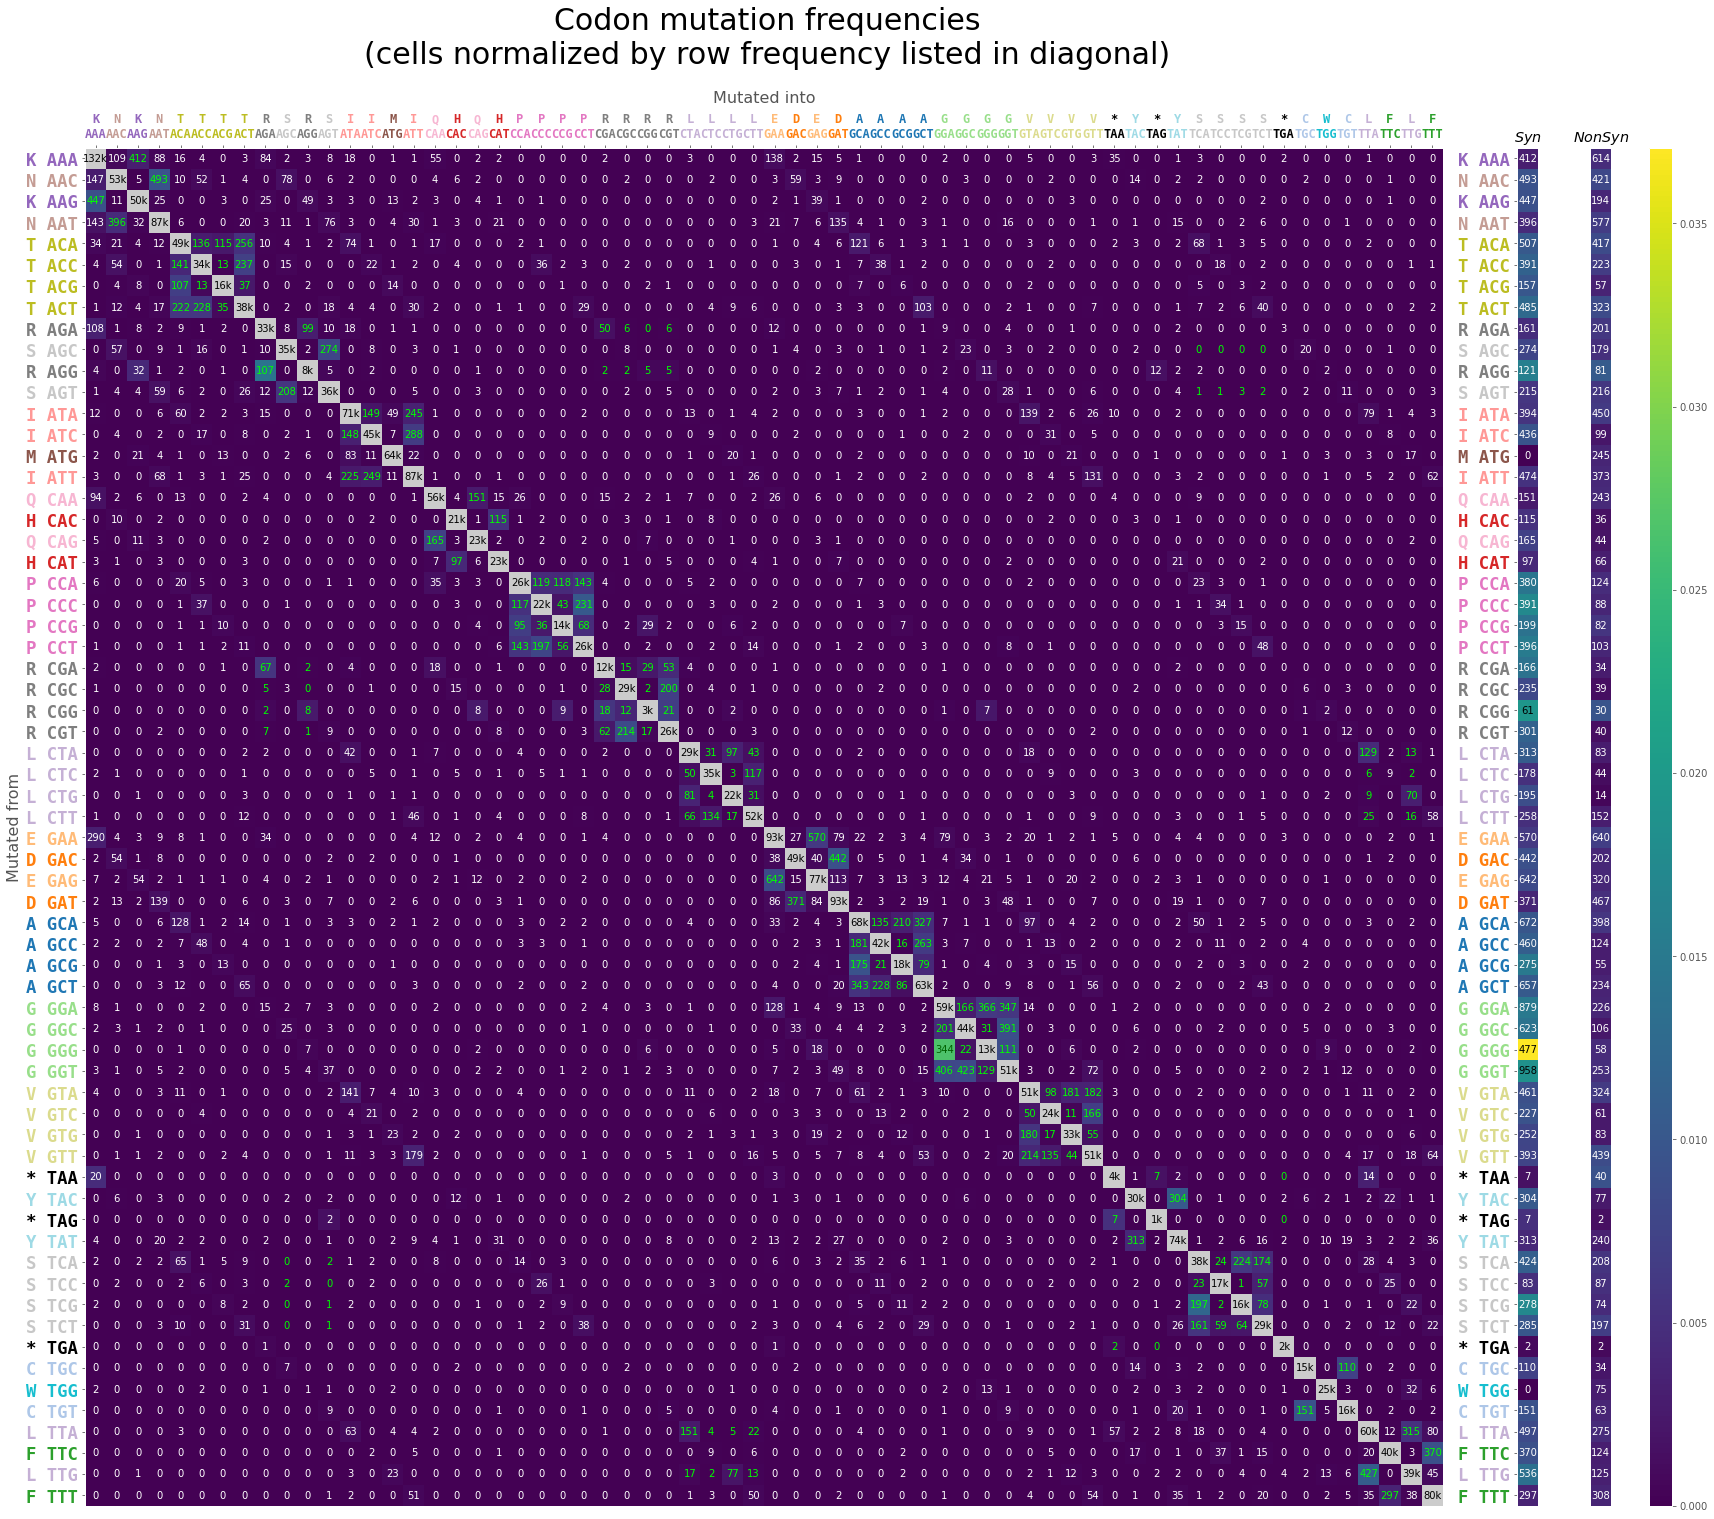

In [28]:
viz_mutmatrix(
    sorted(codon2freq.keys()), codon2freq, codon2codon2freq, "Codon",
    "viridis",
    show_syn_nonsyn_vectors=True,
    w=27.25, h=21,
    figfilename="codon-matrix.png"
)

Most common codon mutations:
1. GAG --> GAA: frequency 642
2. GAA --> GAG: frequency 570
3. AAC --> AAT: frequency 493
4. AAG --> AAA: frequency 447
5. GAC --> GAT: frequency 442
6. TTG --> TTA: frequency 427
7. GGT --> GGC: frequency 423
8. AAA --> AAG: frequency 412
9. GGT --> GGA: frequency 406
10. AAT --> AAC: frequency 396


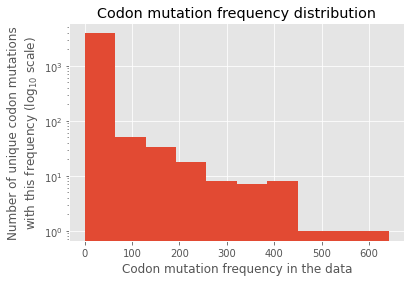

In [29]:
plot_freq_distribution(codon2codon2freq, "Codon")

### Amino acid (+ stop codon) matrix

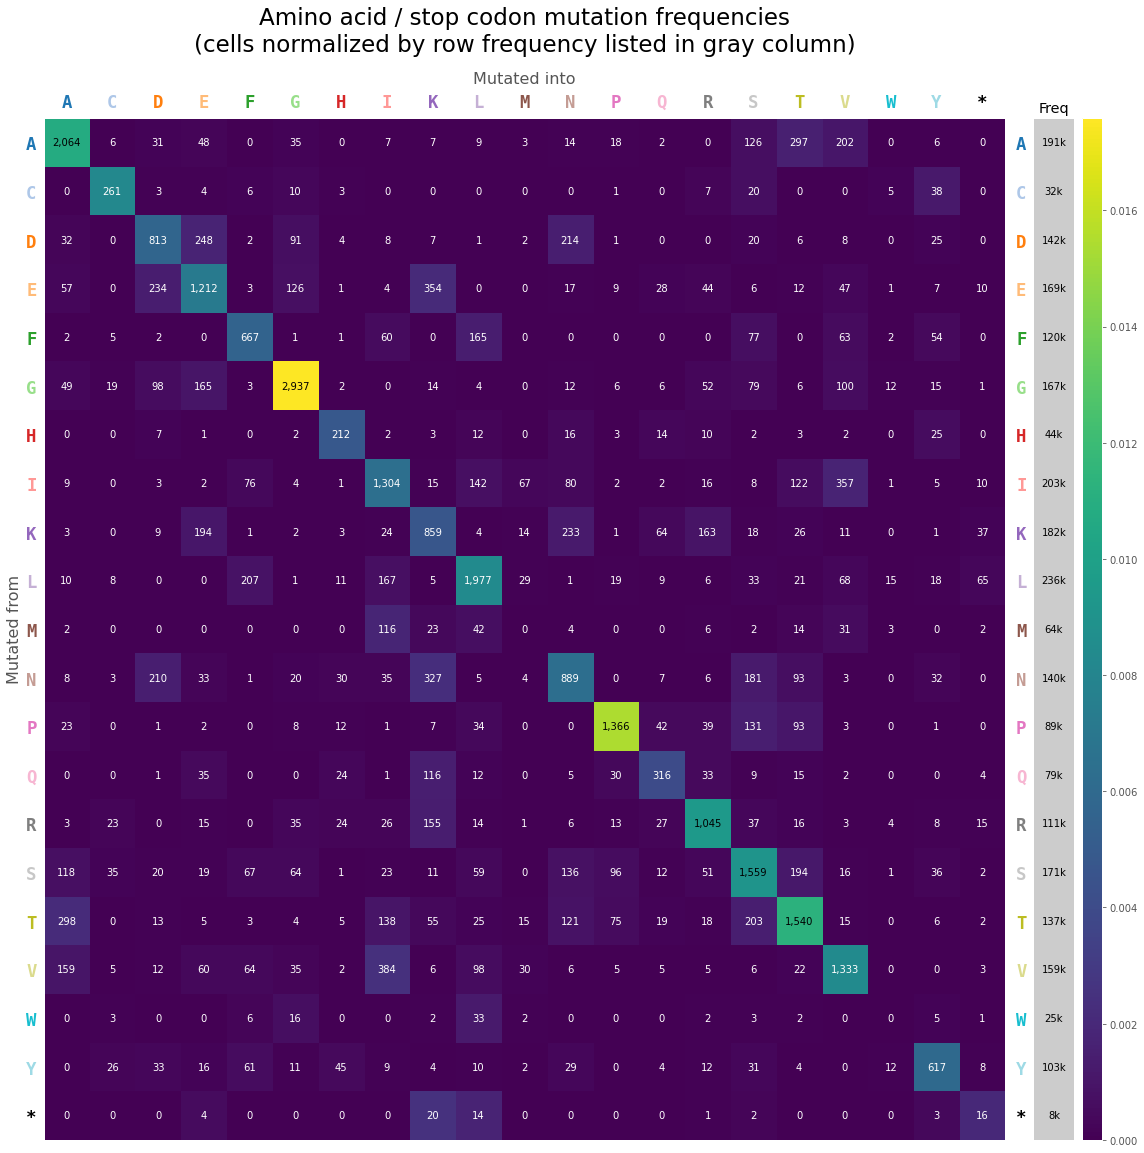

In [30]:
# Sorting will, by default, put the "*" (the stop codon) at the start of the list. To avoid this,
# we manually remove it from the list and then move it to the end (which IMO makes the most sense as
# a location for it relative to the actual amino acids).
aas = sorted(aa2freq.keys())
aas.remove("*")
aas += ["*"]
viz_mutmatrix(
    aas, aa2freq, aa2aa2freq, "Amino acid / stop codon",
    "viridis",
    w=16, h=16,
    rotate_xlabels=False,
    show_ticks=False,
    figfilename="aa-matrix.png",
    custom_diag_map=aa2synmutfreq
)

Most common amino acid / stop codon mutations:
1. V --> I: frequency 384
2. I --> V: frequency 357
3. E --> K: frequency 354
4. N --> K: frequency 327
5. T --> A: frequency 298
6. A --> T: frequency 297
7. D --> E: frequency 248
8. E --> D: frequency 234
9. K --> N: frequency 233
10. D --> N: frequency 214


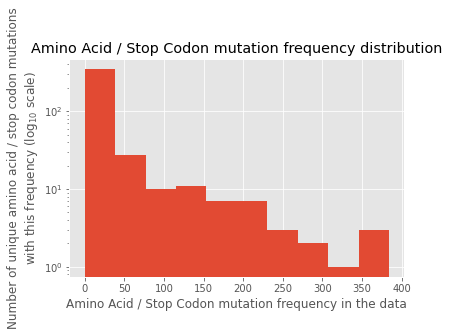

In [31]:
plot_freq_distribution(aa2aa2freq, "Amino Acid / Stop Codon")

### Matrices without row normalization

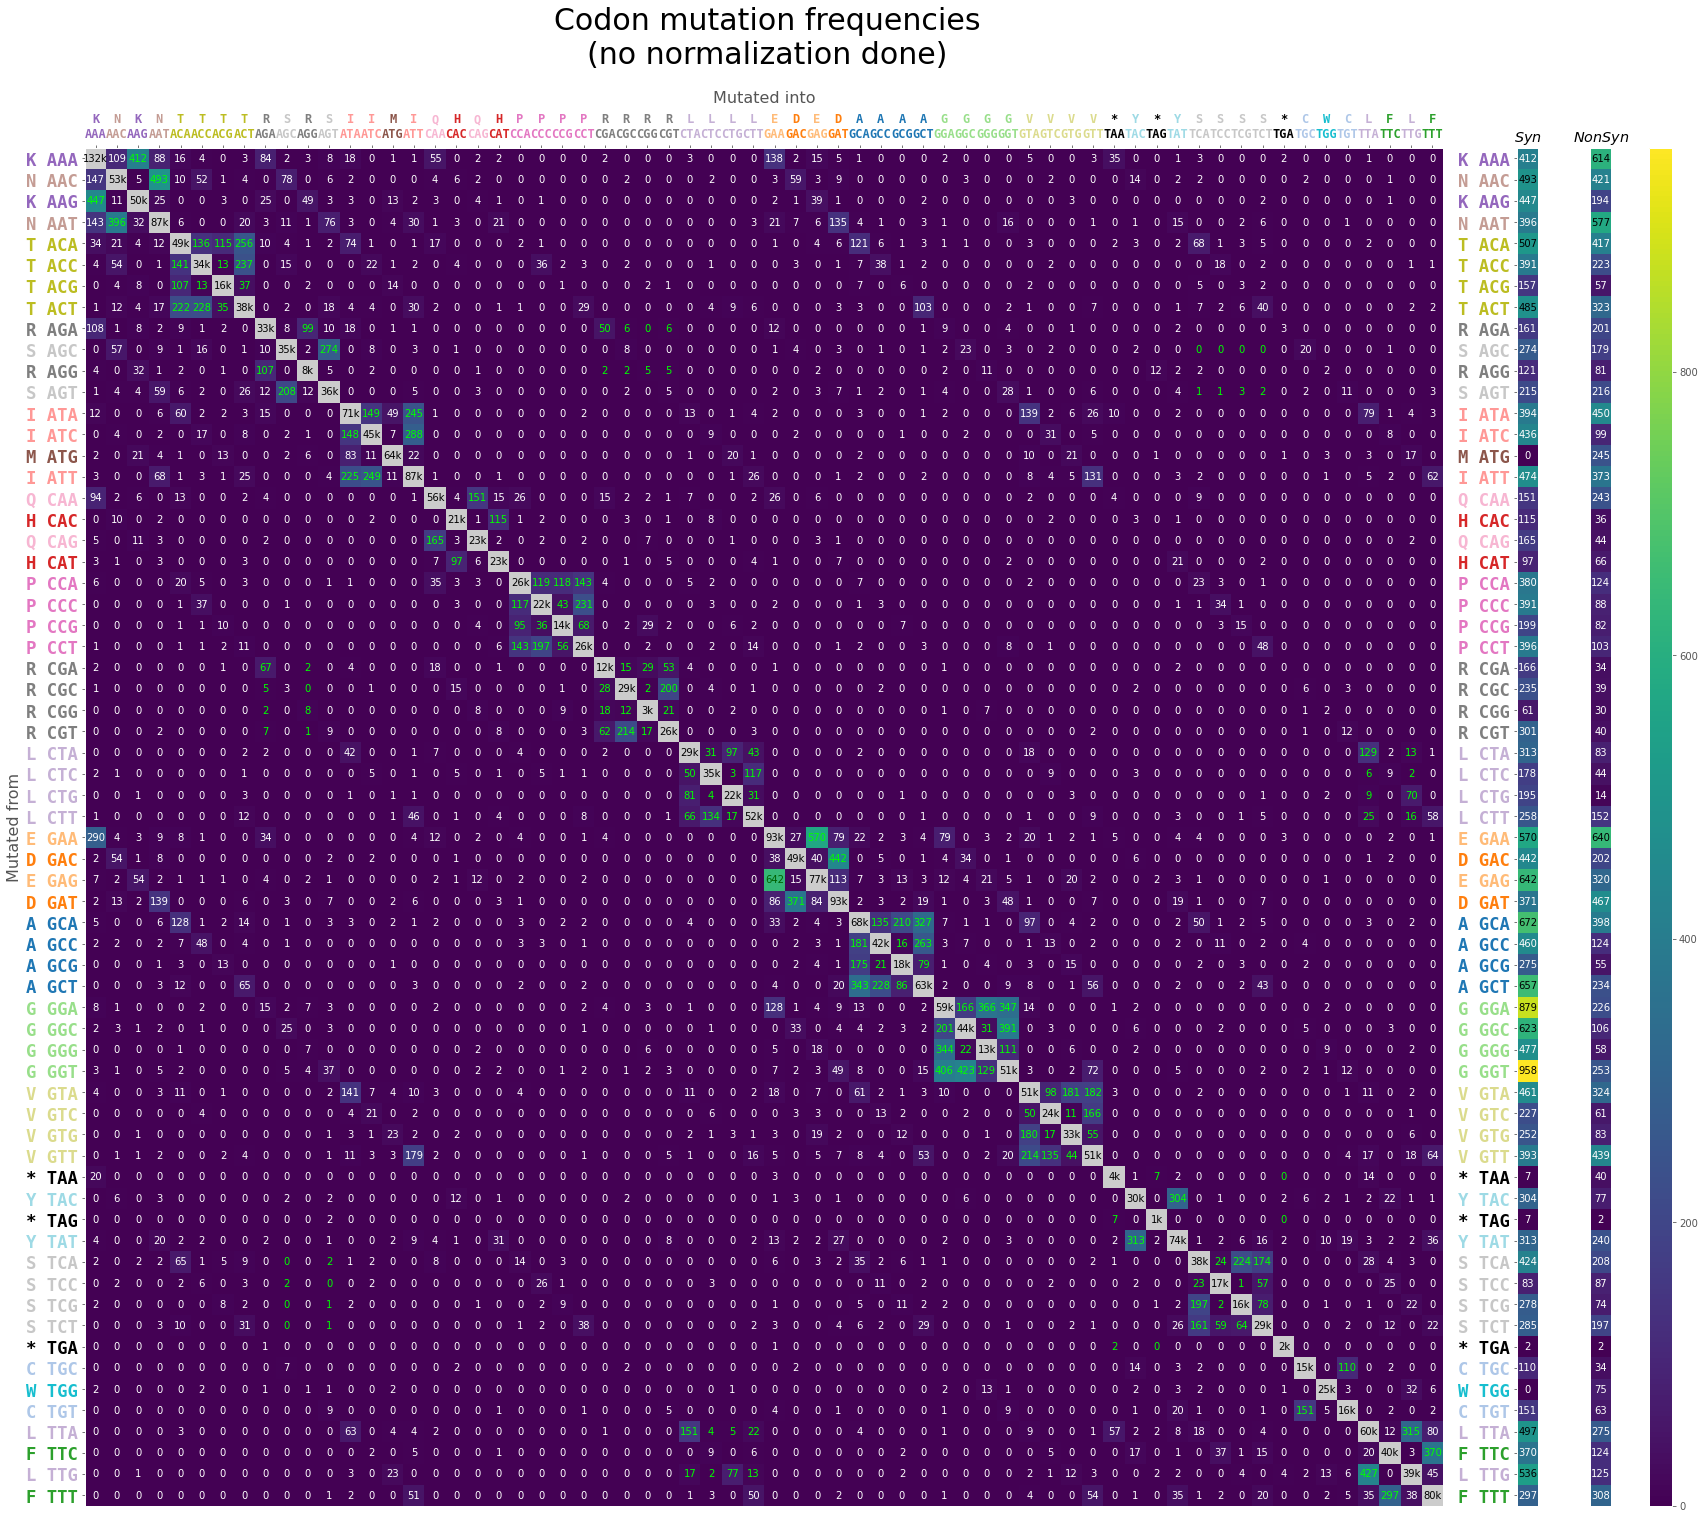

In [32]:
viz_mutmatrix(
    sorted(codon2freq.keys()), codon2freq, codon2codon2freq, "Codon",
    "viridis",
    show_syn_nonsyn_vectors=True,
    w=27.25, h=21,
    normalize_rows=False,
    figfilename="codon-matrix-unnorm.png"
)

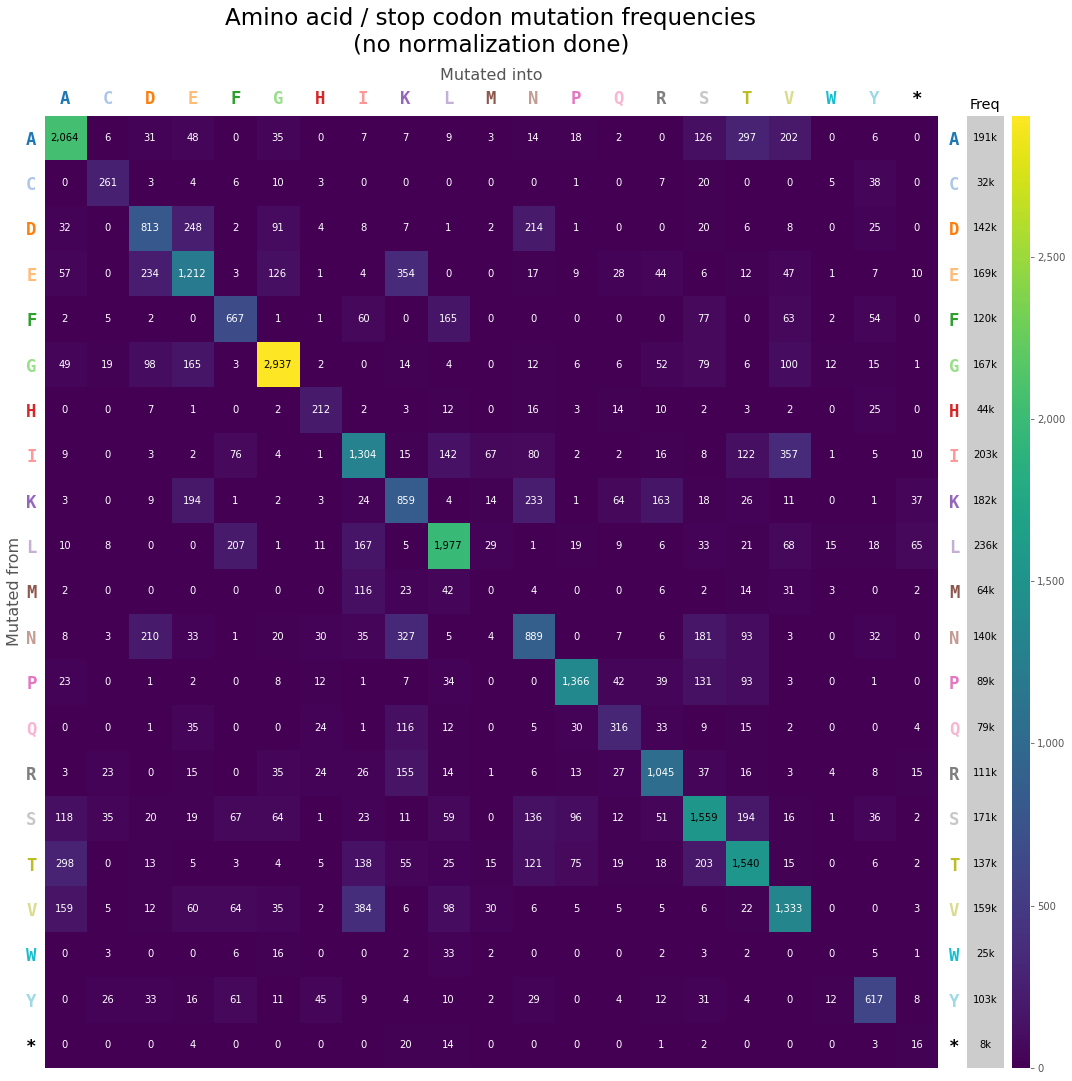

In [41]:
viz_mutmatrix(
    aas, aa2freq, aa2aa2freq, "Amino acid / stop codon",
    "viridis",
    w=15, h=15,
    rotate_xlabels=False,
    show_ticks=False,
    normalize_rows=False,
    figfilename="aa-matrix-unnorm.png",
    custom_diag_map=aa2synmutfreq
)